# Data Science Workflow

## First Session and Accessing Collections

In [1]:
import os
from pyspark.sql import SparkSession

jar_folder = "/opt/extra_jars"
jars = [os.path.join(jar_folder, f) for f in os.listdir(jar_folder) if f.endswith('.jar')]
jars_string = ",".join(jars)

if 'spark' in locals():
    spark.stop()

spark = (SparkSession.builder
    .appName("DataScienceWeatherAndDelay")
    .master("spark://spark-master:7077")
    .config("spark.jars", jars_string)
    .config("spark.mongodb.read.connection.uri", "mongodb://mongodb:27017/big_data_austria")
    .getOrCreate())


df_weather = (spark.read
    .format("mongodb")
    .option("collection", "Station_HW_25")
    .load())

df_weather.printSchema()

root
 |-- FF: double (nullable = true)
 |-- P: double (nullable = true)
 |-- RF: double (nullable = true)
 |-- RR: double (nullable = true)
 |-- SO: double (nullable = true)
 |-- TL: double (nullable = true)
 |-- _id: string (nullable = true)
 |-- station_id: string (nullable = true)
 |-- timestamp: string (nullable = true)



### Let's have a first look at the data

In [2]:
df_weather.limit(5).toPandas()

,FF,P,RF,RR,SO,TL,_id,station_id,timestamp
0,0.3,993.5,78.0,0.0,0.0,8.7,69694bb7616de82a3e744633,HW_25,2025-11-01T00:00+00:00
1,0.5,993.5,79.0,0.0,0.0,8.5,69694bb7616de82a3e744634,HW_25,2025-11-01T00:10+00:00
2,1.2,993.7,80.0,0.0,0.0,8.5,69694bb7616de82a3e744635,HW_25,2025-11-01T00:20+00:00
3,0.6,993.6,82.0,0.0,0.0,8.3,69694bb7616de82a3e744636,HW_25,2025-11-01T00:30+00:00
4,0.4,993.6,82.0,0.0,0.0,8.3,69694bb7616de82a3e744637,HW_25,2025-11-01T00:40+00:00


In [3]:
from pyspark.sql import functions as F

weather_cols = ["FF", "P", "RF", "RR", "SO", "TL"]

df_weather_numeric = df_weather
for col_name in weather_cols:
    df_weather_numeric = df_weather_numeric.withColumn(
        col_name, 
        F.col(col_name).cast("double")
    )

df_weather_numeric.select(weather_cols).describe().show()

+-------+----+-----+----+----+----+----+
|summary|  FF|    P|  RF|  RR|  SO|  TL|
+-------+----+-----+----+----+----+----+
|  count|8641| 8641|8641|8641|8641|8641|
|   mean| NaN|  NaN| NaN| NaN| NaN| NaN|
| stddev| NaN|  NaN| NaN| NaN| NaN| NaN|
|    min| 0.0|974.9|36.0| 0.0| 0.0|-5.0|
|    max| NaN|  NaN| NaN| NaN| NaN| NaN|
+-------+----+-----+----+----+----+----+



#### We can see a lot of NaN
Lets drop rows with empty values

In [4]:
df_weather_clean = df_weather_numeric.dropna()

df_weather_clean.select(weather_cols).describe().show()
df_weather_clean.count()

+-------+------------------+-----------------+------------------+--------------------+------------------+-----------------+
|summary|                FF|                P|                RF|                  RR|                SO|               TL|
+-------+------------------+-----------------+------------------+--------------------+------------------+-----------------+
|  count|              8630|             8630|              8630|                8630|              8630|             8630|
|   mean|2.8471031286210775|993.8845538818024|  85.7406720741599|0.007844727694090406|48.432908458864425|4.044681344148318|
| stddev| 1.853571239225058|6.307057515858112|12.519335487563836|0.050284751726957504|157.25770770537704|3.684232861554036|
|    min|               0.0|            974.9|              36.0|                 0.0|               0.0|             -5.0|
|    max|              11.2|           1006.9|             100.0|                 1.2|             600.0|             18.5|
+-------

8630

In [5]:
df_weather_clean.drop('_id', 'station_id').show(3)

+---+-----+----+---+---+---+--------------------+
| FF|    P|  RF| RR| SO| TL|           timestamp|
+---+-----+----+---+---+---+--------------------+
|0.3|993.5|78.0|0.0|0.0|8.7|2025-11-01T00:00+...|
|0.5|993.5|79.0|0.0|0.0|8.5|2025-11-01T00:10+...|
|1.2|993.7|80.0|0.0|0.0|8.5|2025-11-01T00:20+...|
+---+-----+----+---+---+---+--------------------+
only showing top 3 rows



In [6]:
#Check if timestamp loaded correctly into the df
df_weather_clean.select("timestamp").show(3, truncate=False)

+----------------------+
|timestamp             |
+----------------------+
|2025-11-01T00:00+00:00|
|2025-11-01T00:10+00:00|
|2025-11-01T00:20+00:00|
+----------------------+
only showing top 3 rows



In [7]:
df_incidents = spark.read.format("mongodb") \
    .option("database", "big_data_austria") \
    .option("collection", "wienerlinien_historical") \
    .load()

df_incidents.printSchema()
df_incidents.limit(2).toPandas()

root
 |-- PartitionKey: string (nullable = true)
 |-- RowKey: string (nullable = true)
 |-- _id: string (nullable = true)
 |-- category: string (nullable = true)
 |-- data: struct (nullable = true)
 |    |-- attributes: struct (nullable = true)
 |    |    |-- ausBis: string (nullable = true)
 |    |    |-- ausVon: string (nullable = true)
 |    |    |-- location: string (nullable = true)
 |    |    |-- reason: string (nullable = true)
 |    |    |-- relatedLineTypes: struct (nullable = true)
 |    |    |    |-- : string (nullable = true)
 |    |    |    |-- 1: string (nullable = true)
 |    |    |    |-- 10: string (nullable = true)
 |    |    |    |-- 10A: string (nullable = true)
 |    |    |    |-- 11: string (nullable = true)
 |    |    |    |-- 11A: string (nullable = true)
 |    |    |    |-- 12: string (nullable = true)
 |    |    |    |-- 12A: string (nullable = true)
 |    |    |    |-- 13A: string (nullable = true)
 |    |    |    |-- 14A: string (nullable = true)
 |    |    

,PartitionKey,RowKey,_id,category,data,dataHash,endDate,exportDate,firstSeen,imported_at,...,nameFilter,owner,priority,refTrafficInfoCategoryId,resumeDate,source_url,tableName,timestart,title,totalEntities
0,stoerunglang,bms_I20251110-0004_034fad69,69694c7da8e48844827dc6e8,stoerunglang,"((None, None, None, None, (None, None, None, N...",034fad69,2026-05-31T23:55:00.000+0100,2025-12-16T13:39:15.722843+01:00,2025-11-29T04:11:17.977181+01:00,2026-01-15T20:22:21.417852+00:00,...,None,WL,1,2,,https://cipfileshareprod.blob.core.windows.net...,trafficInfoListv2,2025-11-10T05:00:00.000+0100,80A: Bauarbeiten,31112
1,stoerunglang,bms_I20251110-0004_05f679e8,69694c7da8e48844827dc6e9,stoerunglang,"((None, None, None, None, (None, None, None, N...",05f679e8,2026-05-31T23:55:00.000+0100,2025-12-16T13:39:15.722843+01:00,2025-11-29T23:35:01.876868+01:00,2026-01-15T20:22:21.417852+00:00,...,None,WL,1,2,,https://cipfileshareprod.blob.core.windows.net...,trafficInfoListv2,2025-11-10T05:00:00.000+0100,80A: Bauarbeiten,31112


In [8]:
from pyspark.sql import functions as F
import random

df_selected = df_incidents.select(
    F.col("PartitionKey"),
    F.col("endDate"),
    F.col("name"),
    F.col("timestart"),
    F.col("title"),
    # Hier sind die Arrays (Listen) der Linien
    F.col("data.relatedLines").alias("relatedLines_data")
)

df_selected.printSchema()
df_selected.limit(1).toPandas()

root
 |-- PartitionKey: string (nullable = true)
 |-- endDate: string (nullable = true)
 |-- name: string (nullable = true)
 |-- timestart: string (nullable = true)
 |-- title: string (nullable = true)
 |-- relatedLines_data: array (nullable = true)
 |    |-- element: string (containsNull = true)



,PartitionKey,endDate,name,timestart,title,relatedLines_data
0,stoerunglang,2026-05-31T23:55:00.000+0100,bms_I20251110-0004,2025-11-10T05:00:00.000+0100,80A: Bauarbeiten,[80A]


In [9]:
from pyspark.sql import functions as F

# Wir nehmen deinen selektierten DataFrame
df_incidents_final = df_selected.withColumn(
    "timestart", F.to_timestamp("timestart")
).withColumn(
    "endDate", F.to_timestamp("endDate")
)

# Falls du sie für einen Export oder Anzeige EXAKT als String in diesem Format brauchst:
# df_incidents_final = df_incidents_final.withColumn(
#     "timestart_str", F.date_format("timestart", "yyyy-MM-dd'T'HH:mm:ssXXX")
# )

print("Schema nach der Formatierung:")
df_incidents_final.printSchema()

df_incidents_final.select("title", "timestart", "endDate").show(5, truncate=False)

Schema nach der Formatierung:
root
 |-- PartitionKey: string (nullable = true)
 |-- endDate: timestamp (nullable = true)
 |-- name: string (nullable = true)
 |-- timestart: timestamp (nullable = true)
 |-- title: string (nullable = true)
 |-- relatedLines_data: array (nullable = true)
 |    |-- element: string (containsNull = true)

+----------------+-------------------+-------------------+
|title           |timestart          |endDate            |
+----------------+-------------------+-------------------+
|80A: Bauarbeiten|2025-11-10 04:00:00|2026-05-31 22:55:00|
|80A: Bauarbeiten|2025-11-10 04:00:00|2026-05-31 22:55:00|
|80A: Bauarbeiten|2025-11-10 04:00:00|2026-05-31 22:55:00|
|80A: Bauarbeiten|2025-11-10 04:00:00|2026-05-31 22:55:00|
|80A: Bauarbeiten|2025-11-10 04:00:00|2026-05-31 22:55:00|
+----------------+-------------------+-------------------+
only showing top 5 rows



In [10]:
from pyspark.sql import functions as F

#Calculate the difference to get duration
df_duration = df_incidents_final.withColumn(
    "diff_seconds", 
    F.unix_timestamp("endDate") - F.unix_timestamp("timestart")
)

#Translate into h m s format
df_duration = df_duration.withColumn(
    "duration",
    F.concat(
        F.format_string("%02d", (F.col("diff_seconds") / 3600).cast("int")), F.lit("h "),
        F.format_string("%02d", ((F.col("diff_seconds") % 3600) / 60).cast("int")), F.lit("m "),
        F.format_string("%02d", (F.col("diff_seconds") % 60).cast("int")), F.lit("s")
    )
)

df_duration.select("title", "timestart", "endDate", "duration").show(5, truncate=False)

+----------------+-------------------+-------------------+-------------+
|title           |timestart          |endDate            |duration     |
+----------------+-------------------+-------------------+-------------+
|80A: Bauarbeiten|2025-11-10 04:00:00|2026-05-31 22:55:00|4866h 55m 00s|
|80A: Bauarbeiten|2025-11-10 04:00:00|2026-05-31 22:55:00|4866h 55m 00s|
|80A: Bauarbeiten|2025-11-10 04:00:00|2026-05-31 22:55:00|4866h 55m 00s|
|80A: Bauarbeiten|2025-11-10 04:00:00|2026-05-31 22:55:00|4866h 55m 00s|
|80A: Bauarbeiten|2025-11-10 04:00:00|2026-05-31 22:55:00|4866h 55m 00s|
+----------------+-------------------+-------------------+-------------+
only showing top 5 rows



In [11]:
df_duration = df_duration.withColumn(
    "diff_seconds", 
    F.unix_timestamp("endDate") - F.unix_timestamp("timestart")
)

# Kurze Kontrolle der Werte
df_duration.select("title", "timestart", "endDate", "diff_seconds", "duration").show(5)

+----------------+-------------------+-------------------+------------+-------------+
|           title|          timestart|            endDate|diff_seconds|     duration|
+----------------+-------------------+-------------------+------------+-------------+
|80A: Bauarbeiten|2025-11-10 04:00:00|2026-05-31 22:55:00|    17520900|4866h 55m 00s|
|80A: Bauarbeiten|2025-11-10 04:00:00|2026-05-31 22:55:00|    17520900|4866h 55m 00s|
|80A: Bauarbeiten|2025-11-10 04:00:00|2026-05-31 22:55:00|    17520900|4866h 55m 00s|
|80A: Bauarbeiten|2025-11-10 04:00:00|2026-05-31 22:55:00|    17520900|4866h 55m 00s|
|80A: Bauarbeiten|2025-11-10 04:00:00|2026-05-31 22:55:00|    17520900|4866h 55m 00s|
+----------------+-------------------+-------------------+------------+-------------+
only showing top 5 rows



In [12]:
from pyspark.sql import functions as F

# Basic statistical analysis for the duration in seconds
df_duration.select("diff_seconds").summary().show()

# If you want to see the average duration per incident type (title)
df_duration.groupBy("title") \
    .agg(
        F.count("diff_seconds").alias("incident_count"),
        F.round(F.avg("diff_seconds") / 3600, 2).alias("avg_hours"),
        F.round(F.avg("diff_seconds"), 2).alias("avg_seconds"),
        F.min("diff_seconds").alias("min_seconds"),
        F.max("diff_seconds").alias("max_seconds")
    ) \
    .orderBy(F.desc("avg_seconds")) \
    .show(30, truncate=False)

+-------+-----------------+
|summary|     diff_seconds|
+-------+-----------------+
|  count|            29950|
|   mean|896618.8775626044|
| stddev|3290477.818410084|
|    min|              151|
|    25%|             3570|
|    50%|            30000|
|    75%|            53700|
|    max|         71370000|
+-------+-----------------+

+-------------------------------------------------------+--------------+---------+-------------+-----------+-----------+
|title                                                  |incident_count|avg_hours|avg_seconds  |min_seconds|max_seconds|
+-------------------------------------------------------+--------------+---------+-------------+-----------+-----------+
|Busse halten bei\nNeubaugasse 69                       |1             |19825.0  |7.137E7      |71370000   |71370000   |
|U6: Bauarbeiten                                        |216           |6359.0   |2.28924E7    |22892400   |22892400   |
|80A: Bauarbeiten                                       |1

In [13]:
df_incidents.groupBy("PartitionKey").count().orderBy("PartitionKey").show()

+---------------+-----+
|   PartitionKey|count|
+---------------+-----+
|    aufzugsinfo|  956|
|fahrtreppeninfo| 1013|
|   stoerungkurz|10012|
|   stoerunglang|17256|
|        unknown| 1875|
+---------------+-----+



In [14]:
from pyspark.sql import functions as F

# Liste der Keys, die wir löschen/droppen wollen
keys_to_drop = ["aufzugsinfo", "fahrtreppeninfo"]

# Wir filtern den DataFrame: Behalte nur Zeilen, deren PartitionKey NICHT in der Liste ist
df_filtered = df_duration.filter(~F.col("PartitionKey").isin(keys_to_drop))

# Check: Jetzt sollten nur noch die anderen Keys übrig sein
df_filtered.groupBy("PartitionKey").count().show()


+------------+-----+
|PartitionKey|count|
+------------+-----+
|     unknown| 1875|
|stoerunglang|17256|
|stoerungkurz|10012|
+------------+-----+



In [15]:
# Basic statistical analysis for the duration in seconds
df_filtered.select("diff_seconds").summary().show()

# If you want to see the average duration per incident type (title)
df_filtered.groupBy("title") \
    .agg(
        F.count("diff_seconds").alias("incident_count"),
        F.round(F.avg("diff_seconds") / 3600, 2).alias("avg_hours"),
        F.round(F.avg("diff_seconds"), 2).alias("avg_seconds"),
        F.min("diff_seconds").alias("min_seconds"),
        F.max("diff_seconds").alias("max_seconds")
    ) \
    .orderBy(F.desc("avg_seconds")) \
    .show(5, truncate=False)

+-------+-----------------+
|summary|     diff_seconds|
+-------+-----------------+
|  count|            29143|
|   mean|921033.5512129843|
| stddev|3332408.913338938|
|    min|              151|
|    25%|             3564|
|    50%|            31800|
|    75%|            55800|
|    max|         71370000|
+-------+-----------------+

+--------------------------------+--------------+---------+-------------+-----------+-----------+
|title                           |incident_count|avg_hours|avg_seconds  |min_seconds|max_seconds|
+--------------------------------+--------------+---------+-------------+-----------+-----------+
|Busse halten bei\nNeubaugasse 69|1             |19825.0  |7.137E7      |71370000   |71370000   |
|U6: Bauarbeiten                 |216           |6359.0   |2.28924E7    |22892400   |22892400   |
|80A: Bauarbeiten                |106           |4866.92  |1.75209E7    |17520900   |17520900   |
|18: Gleisbauarbeiten            |1759          |2910.31  |1.047711899E7|94

In [17]:
from pyspark.sql import functions as F

# Wir definieren die Spalten, die einen Vorfall eindeutig beschreiben
id_columns = ["timestart", "title"]

# Mehrfache Meldungen finden
duplicates = df_filtered.groupBy(id_columns) \
    .count() \
    .filter("count > 1") \
    .orderBy(F.desc("count"))

duplicates.show(5, truncate=False)

+-------------------+-------------------------+-----+
|timestart          |title                    |count|
+-------------------+-------------------------+-----+
|2025-09-01 04:30:00|18: Gleisbauarbeiten     |1759 |
|2025-11-25 04:37:54|Endstation  für Gewalt!  |258  |
|2025-11-28 13:00:00|1, 2, D, 71: Staatsbesuch|248  |
|2025-05-11 23:55:00|U6: Bauarbeiten          |216  |
|2025-11-30 15:10:00|76A, 76B: Bauarbeiten    |209  |
+-------------------+-------------------------+-----+
only showing top 5 rows



In [18]:
# Entfernt alle Zeilen, die in timestart, title und location identisch sind
df_unique_incidents = df_filtered.dropDuplicates(id_columns)

print(f"Initial: {df_filtered.count()}")
print(f"Cleaned: {df_unique_incidents.count()}")

Initial: 29143
Cleaned: 6166


In [19]:
df_unique_incidents.limit(5).toPandas()

,PartitionKey,endDate,name,timestart,title,relatedLines_data,diff_seconds,duration
0,stoerungkurz,2025-11-11 11:20:00,ivu_664_-2,2023-08-08 10:20:00,Busse halten bei\nNeubaugasse 69,None,71370000,19825h 00m 00s
1,stoerunglang,2026-01-31 22:55:00,bms_I20250512-0001,2025-05-11 23:55:00,U6: Bauarbeiten,[U6],22892400,6359h 00m 00s
2,stoerunglang,2026-01-01 01:00:00,bms_I20250901-0001,2025-09-01 04:30:00,18: Gleisbauarbeiten,[18],10528200,2924h 30m 00s
3,stoerunglang,2025-12-05 00:00:00,bms_I20250922-0003,2025-09-22 04:25:00,U4: Bauarbeiten,[U4],6377700,1771h 35m 00s
4,stoerunglang,2025-11-30 22:55:00,bms_I20251001-0019,2025-10-01 09:50:00,38A: Gleisbauarbeiten,[38A],5231100,1453h 05m 00s


In [20]:
# Wir behalten alle Zeilen, die NICHT (~) dem Muster "bauarbeit" entsprechen
df_no_construction = df_unique_incidents.filter(~F.col("title").rlike("(?i)bauarbeit"))

# Kurzer Check: Wie viele Zeilen wurden entfernt?
print(f"Inital: {df_unique_incidents.count()}")
print(f"Cleaned: {df_no_construction.count()}")

# Zeige die ersten Titel zur Kontrolle
df_no_construction.limit(10).toPandas()

Inital: 6166
Cleaned: 5756


,PartitionKey,endDate,name,timestart,title,relatedLines_data,diff_seconds,duration
0,stoerungkurz,2025-11-11 11:20:00,ivu_664_-2,2023-08-08 10:20:00,Busse halten bei\nNeubaugasse 69,None,71370000,19825h 00m 00s
1,stoerungkurz,2025-11-03 22:59:59,ivu_739_399,2025-11-02 21:25:02,Testtext GSC200 Test für LB / WLB und Lauftext,[WLB],92097,25h 34m 57s
2,stoerungkurz,2025-11-03 14:19:00,ivu_12_102,2025-11-03 13:19:24,Fahrtbehinderung wegen Rettungseinsatz,[2],3576,00h 59m 36s
3,stoerungkurz,2025-11-03 14:33:00,ivu_144_0,2025-11-03 13:33:31,Falschparker Umeltung bis Volksoper über Linie...,None,3569,00h 59m 29s
4,stoerunglang,2025-11-03 22:55:00,bms_I20251103-0023-F01,2025-11-03 14:15:00,U1: Betriebsstörung,[U1],31200,08h 40m 00s
5,stoerunglang,2025-11-03 22:55:00,bms_I20251103-0024-F01,2025-11-03 14:20:00,U3: Rettungseinsatz,[U3],30900,08h 35m 00s
6,stoerunglang,2025-11-03 22:55:00,bms_I20251103-0025,2025-11-03 15:20:00,59A: Verkehrsüberlastung,[59A],27300,07h 35m 00s
7,stoerunglang,2025-11-03 22:55:00,bms_I20251103-0026-F01,2025-11-03 15:35:00,U2: Schadhaftes Fahrzeug,[U2],26400,07h 20m 00s
8,stoerunglang,2025-11-03 22:55:00,bms_I20251103-0027-F01,2025-11-03 15:55:00,13A: Schadhaftes Fahrzeug,[13A],25200,07h 00m 00s
9,stoerungkurz,2025-11-03 17:05:00,ivu_662_413,2025-11-03 15:57:27,Fahrtbehinderung Falschparker,[13A],4053,01h 07m 33s


In [21]:
# Statistik für die Sekunden
df_no_construction.select("diff_seconds").summary().show()

# Anzeige in Minuten für bessere Lesbarkeit
df_no_construction.select(
    (F.col("diff_seconds") / 60).alias("duration_minutes")
).summary().show()

+-------+------------------+
|summary|      diff_seconds|
+-------+------------------+
|  count|              5756|
|   mean|32388.793954134817|
| stddev| 940784.4368027849|
|    min|               151|
|    25%|              3529|
|    50%|              6266|
|    75%|             33000|
|    max|          71370000|
+-------+------------------+

+-------+------------------+
|summary|  duration_minutes|
+-------+------------------+
|  count|              5756|
|   mean| 539.8132325689139|
| stddev|15679.740613379752|
|    min|2.5166666666666666|
|    25%| 58.81666666666667|
|    50%|104.43333333333334|
|    75%|             550.0|
|    max|         1189500.0|
+-------+------------------+



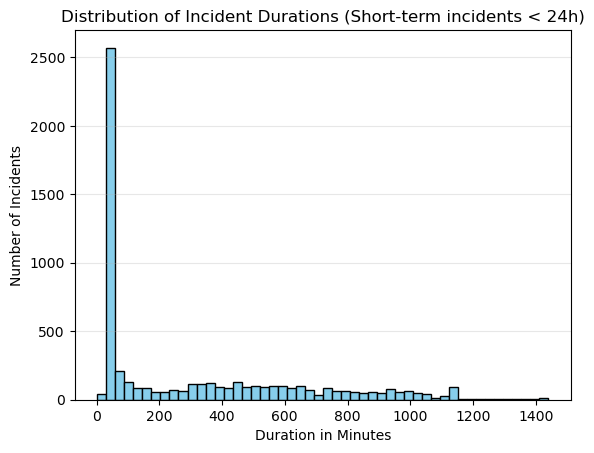

In [22]:
import matplotlib.pyplot as plt
from pyspark.sql import functions as F

# Filter for realistic daily incidents (under 24h) to avoid squashing the plot
# and convert seconds to minutes
plot_df = df_no_construction.filter(F.col("diff_seconds") < 86400) \
    .select((F.col("diff_seconds") / 60).alias("minutes")) \
    .toPandas()

# Plotting
plt.hist(plot_df['minutes'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Incident Durations (Short-term incidents < 24h)')
plt.xlabel('Duration in Minutes')
plt.ylabel('Number of Incidents')
plt.grid(axis='y', alpha=0.3)
plt.savefig('duration_distribution.png')

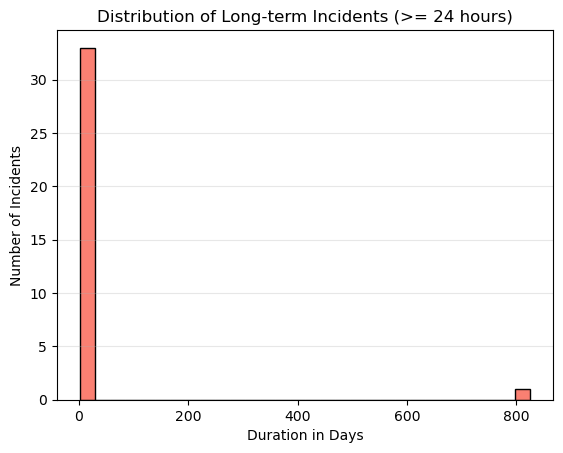

In [23]:
import matplotlib.pyplot as plt
from pyspark.sql import functions as F

# Filter for long-term incidents (24h or longer)
# Convert seconds to days for better readability on the x-axis
plot_df_long = df_no_construction.filter(F.col("diff_seconds") >= 86400) \
    .select((F.col("diff_seconds") / 86400).alias("days")) \
    .toPandas()

# Plotting
plt.hist(plot_df_long['days'], bins=30, color='salmon', edgecolor='black')
plt.title('Distribution of Long-term Incidents (>= 24 hours)')
plt.xlabel('Duration in Days')
plt.ylabel('Number of Incidents')
plt.grid(axis='y', alpha=0.3)
plt.savefig('long_duration_distribution.png')


In [24]:
#We delete longterm incidents over 24h because that is not a delay anymore...
df_final_cleaned = df_no_construction.filter(F.col("diff_seconds") < 86400)

# Kurzer Vorher-Nachher-Vergleich
print(f"Anzahl vor der Bereinigung: {df_no_construction.count()}")
print(f"Anzahl nach der Bereinigung (< 24h): {df_final_cleaned.count()}")

# Überprüfung der neuen Maximaldauer
df_final_cleaned.select(
    F.max("diff_seconds").alias("max_sec"),
    (F.max("diff_seconds") / 3600).alias("max_hours")
).show()

Anzahl vor der Bereinigung: 5756
Anzahl nach der Bereinigung (< 24h): 5722
+-------+------------------+
|max_sec|         max_hours|
+-------+------------------+
|  86381|23.994722222222222|
+-------+------------------+



In [27]:
weather_mapping = {
    "FF": "wind_speed",
    "P": "air_pressure",
    "RF": "relative_humidity",
    "RR": "precipitation",
    "SO": "sunshine_duration",
    "TL": "temperature"
}

# Wir wenden das Mapping auf den DataFrame an
df_weather_named = df_weather_clean
for old_name, new_name in weather_mapping.items():
    df_weather_named = df_weather_named.withColumnRenamed(old_name, new_name)

# Ergebnis prüfen
df_weather_named.select("timestamp", "temperature", "wind_speed", "precipitation").show(3)

+--------------------+-----------+----------+-------------+
|           timestamp|temperature|wind_speed|precipitation|
+--------------------+-----------+----------+-------------+
|2025-11-01T00:00+...|        8.7|       0.3|          0.0|
|2025-11-01T00:10+...|        8.5|       0.5|          0.0|
|2025-11-01T00:20+...|        8.5|       1.2|          0.0|
+--------------------+-----------+----------+-------------+
only showing top 3 rows



In [25]:
(df_final_cleaned.write
    .format("mongodb")
    .option("spark.mongodb.write.connection.uri", "mongodb://mongodb:27017") # Explizite URI
    .option("database", "big_data_austria")
    .option("collection", "wienerlinien_cleaned")
    .mode("overwrite")
    .save())

print("Safed successfully")



Safed successfully


In [28]:
(df_weather_named.write
    .format("mongodb")
    .option("spark.mongodb.write.connection.uri", "mongodb://mongodb:27017") # Explizite URI
    .option("database", "big_data_austria")
    .option("collection", "weather_cleaned")
    .mode("overwrite")
    .save())

print("Safed successfully")

Safed successfully


In [29]:
spark.stop()